In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from GRU_stock_data_processing import *
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

sns.set()
tf.random.set_seed(1234)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Dataset and Select Ticker

In [286]:
stock_df = pd.read_csv("../stock_yfinance_data.csv")
ticker = 'TSLA'
stock_filt = stock_df['Stock Name'] == ticker
tsla_df_raw = stock_df[stock_filt]
tsla_df_raw = tsla_df_raw.iloc[:, [7, 0, 1, 2, 3, 4, 5, 6]]
tsla_df_raw.head()

,Stock Name,Date,Open,High,Low,Close,Adj Close,Volume
0,TSLA,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000
1,TSLA,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200
2,TSLA,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900
3,TSLA,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800
4,TSLA,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400


### Generate Additional Features

In [311]:
tsla_df = clean_stock_data(tsla_df_raw)
tsla_df['sma'] = simple_moving_average(tsla_df)
tsla_df['ema'] = exponential_moving_average(tsla_df)
tsla_df['rsi'] = calculate_rsi(tsla_df)
tsla_df['macd_line'] , tsla_df['macd_signal'], tsla_df['macd_histogram'] = calculate_macd(tsla_df)
tsla_df['bb_middle'], tsla_df['bb_upper'], tsla_df['bb_lower'] = bollinger_bands(tsla_df)
tsla_df['target'] = calculate_closing_diff(tsla_df)

#only keep 20-end because moving avg requires window size 20
tsla_df = tsla_df[20:]
tsla_df.head()

,stock_name,date,open,high,low,close,adj_close,volume,sma,ema,rsi,macd_line,macd_signal,macd_histogram,bb_middle,bb_upper,bb_lower,target
20,TSLA,2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,288.855501,299.727787,96.118171,21.687444,13.249816,8.437628,288.855501,354.015698,223.695304,13.059998
21,TSLA,2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,294.501834,306.547364,96.459875,24.612650,15.522383,9.090267,294.501834,367.635649,221.368019,12.320007
22,TSLA,2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,301.619501,315.720314,97.129203,29.139205,18.245747,10.893457,301.619501,387.433479,215.805523,31.529999
23,TSLA,2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,308.143001,322.858061,89.346741,31.380625,20.872723,10.507902,308.143001,400.300312,215.985690,-12.196686
24,TSLA,2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,315.328168,330.644912,90.094450,33.892197,23.476617,10.415579,315.328168,414.149173,216.507162,13.953339


### Scale Features

In [312]:
data = np.array(tsla_df[:])
data = data[:, 2:]
sc = MinMaxScaler(feature_range=(0,1))
data = sc.fit_transform(data)

### Generate GRU train and test split

In [319]:
#datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=15) #predict closing delta
datax, datay = generate_LSTM_data(data, sequence_size=20, target_idx=3) #predict closing
print('LSTM Data')
print("> Data X: " + str(datax.shape))
print("> Data y: " + str(datay.shape))

test_size = 30
datax_train = datax[:-test_size]
datay_train = datay[:-test_size]
print('Train Set')
print("> Data X: " + str(datax_train.shape))
print("> Data y: " + str(datay_train.shape))
datax_test = datax[-test_size:]
datay_test = datay[-test_size:]
print('Test Set')
print("> Data X: " + str(datax_test.shape))
print("> Data y: " + str(datay_test.shape))

LSTM Data
> Data X: (211, 20, 16)
> Data y: (211,)
Train Set
> Data X: (181, 20, 16)
> Data y: (181,)
Test Set
> Data X: (30, 20, 16)
> Data y: (30,)


### Define Model

In [296]:
class GRU_Model(tf.keras.Model):
    def __init__(self, num_layers, hidden_dim, output_size, dropout_rate=0.1):
        super(GRU_Model, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.output_size = output_size

        self.gru_layers = [
            tf.keras.layers.GRU(
                hidden_dim,
                activation='tanh',
                return_sequences=True
            ) for _ in range(num_layers-1)
        ]
        self.last_gru = tf.keras.layers.GRU(
            hidden_dim,
            activation='tanh',
            return_sequences=False
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dense1 = tf.keras.layers.Dense(hidden_dim//2)
        self.dense2 = tf.keras.layers.Dense(output_size)
    
    def call(self, x):
        for gru_layer in self.gru_layers:
            x = gru_layer(x)
            x = self.dropout(x)
        x = self.last_gru(x)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.dropout(x)
        x = self.dense2(x)
        return x

### Train Model

In [320]:
mymodel = GRU_Model(num_layers=5, hidden_dim=128, output_size=1, dropout_rate=0.1)
mymodel.compile(optimizer="adam", loss="mean_squared_error")
eval = mymodel.evaluate(datax_train, datay_train)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3958  


In [321]:
history = mymodel.fit(
    x = datax_train,
    y = datay_train,
    validation_split=0.25,
    epochs=300,
    batch_size=128
)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.3454 - val_loss: 0.0508
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1632 - val_loss: 0.0265
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0832 - val_loss: 0.0121
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0355 - val_loss: 0.0369
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0472 - val_loss: 0.0418
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0452 - val_loss: 0.0168
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0198 - val_loss: 0.0116
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0286 - val_loss: 0.0154
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0175 - val_loss: 0.0292
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0255 - val_loss: 0.0309
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0297 - val_loss: 0.0169
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0165 - val_lo

### Plot Performance

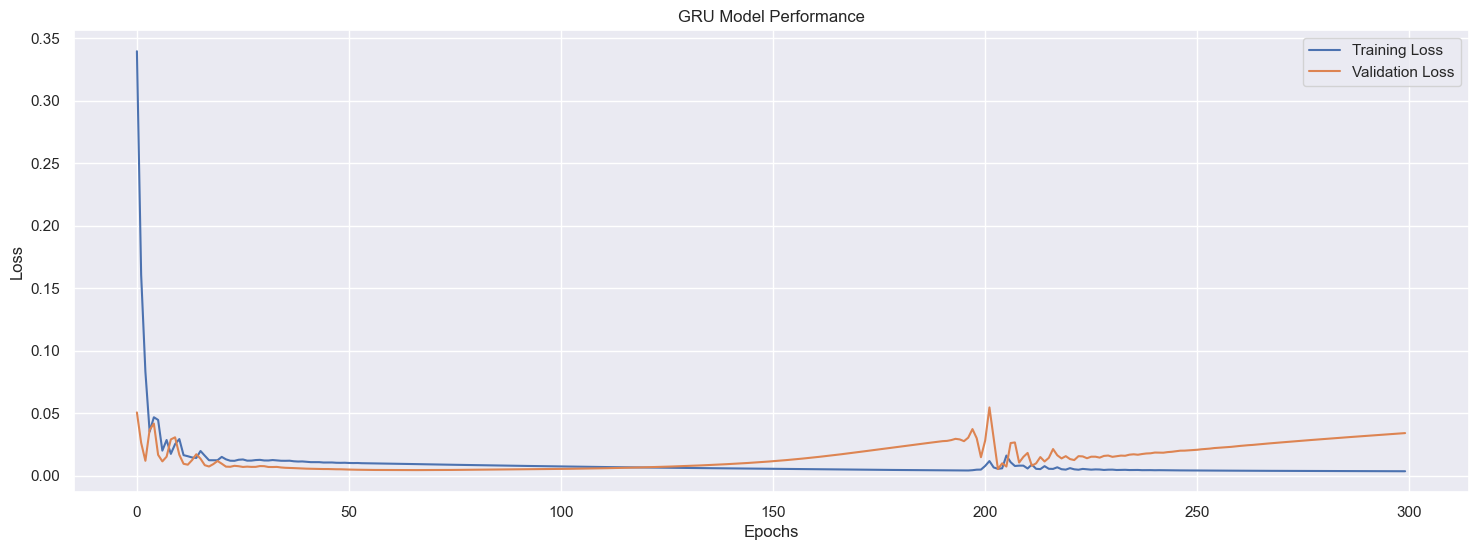

In [322]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("GRU Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


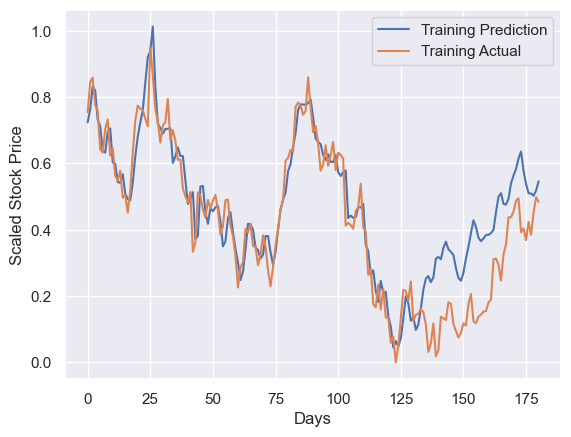

In [323]:
train_predictions = mymodel.predict(datax_train) #Prediction on Data using trained model
plt.plot(train_predictions, label='Training Prediction')
plt.plot(datay_train, label='Training Actual')
plt.xlabel('Days')
plt.ylabel('Scaled Stock Price')
plt.legend()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


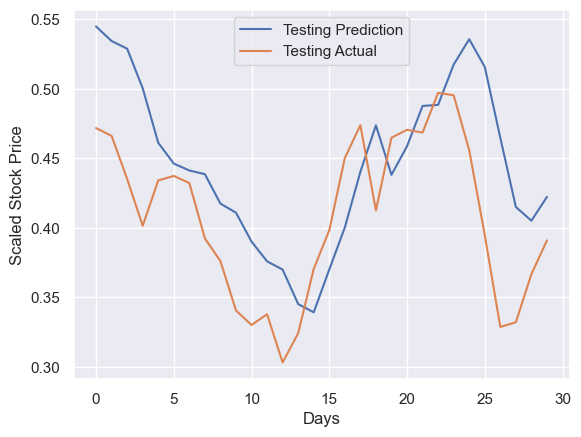

In [324]:
test_predictions = mymodel.predict(datax_test) #Prediction on Data using trained model
plt.plot(test_predictions, label='Testing Prediction')
plt.plot(datay_test, label='Testing Actual')
plt.xlabel('Days')
plt.ylabel('Scaled Stock Price')
plt.legend()